In [7]:
%cd /content/drive/MyDrive/Home_Depot_Case_Study/Workspace3
!pwd

/content/drive/MyDrive/Home_Depot_Case_Study/Workspace3
/content/drive/MyDrive/Home_Depot_Case_Study/Workspace3


# Imports and Utility Functions

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib_venn import venn2
import regex as re
from collections import Counter
!pip install nltk 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from collections import Counter
from nltk.stem import PorterStemmer 
from wordcloud import WordCloud, STOPWORDS 
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer 
from textblob import TextBlob
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import math
import re
import xgboost as xgb
from xgboost import XGBRegressor
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm
import pickle
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint, loguniform
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#Utility Functions
def display_results(results, thresh=0.1):
  ranks = results.cv_results_['rank_test_score']
  ind = np.argsort(ranks)
  sorted_train_scores = np.array(-results.cv_results_['mean_train_score'])[ind]
  sorted_test_scores = np.array(-results.cv_results_['mean_test_score'])[ind]
  sorted_params = np.array(results.cv_results_['params'])[ind]
  
  for i in range(len(ranks)):
    if (sorted_test_scores[i] - sorted_train_scores[i]) < thresh:
      print('train ->', sorted_train_scores[i])
      print('test ->', sorted_test_scores[i])
      print('params ->', sorted_params[i])
      print('*'*100)
    else: 
      continue

def plot_scores_single(results, param, log=False):
  '''
  Here you can use continuous distribution also for the single parameter
  '''
  X = [x[param] for x in results.cv_results_['params']]
  if log:
    X = [math.log10(a) for a in X]
  plt.plot(X, -results.cv_results_['mean_train_score'])
  plt.plot(X, -results.cv_results_['mean_test_score'])
  plt.title('rmse')
  plt.ylabel('rmse')
  plt.xlabel(param)
  plt.legend(['train', 'tets'], loc='lower left')
  plt.show()

# Preparing the Data


* Total Data is divided 80-20 and stored in Train_X, Train_Y, Test_X, Test_Y
* train data Train_X is split further 50-50 into Train_X1, Train_Y1, Train_X2, Train_Y2
* The data Train_X1, Train_Y1 is used for training each base models. 
* Train_X2, Train_Y2 is then used to train the meta classifier 
* For splitting into train and test (80-20) we have used train_test_split and then we always use random_state=122. This step is very important cause the Train_X needs to have the same indices in all the three modelling notebooks. 
* For sampling we use, df.sample(). The sample datasets are succeeded with the characted S. So the first sample data is stored in X1_train_S1 with random state=101. The second in X2_train_S2 with random state 102 and so on the pattern is continued. 

**Features contain the 71 Numerical Features**

In [8]:
data1_train = pd.read_pickle('featurization/train/feature_set1/data1_train.pkl')
data1_train_comb = pd.read_pickle('featurization/train/feature_set1/data1_train_comb.pkl')
data2_train = pd.read_pickle('featurization/train/feature_set2/data2_train.pkl')
data3_train = pd.read_pickle('featurization/train/feature_set3/data3_train.pkl')
print(data1_train_comb.shape, data2_train.shape, data3_train.shape)

Train_X = pd.concat([data1_train_comb, data2_train, data3_train], axis=1)
Train_Y = data1_train['relevance']
print(Train_X.shape, Train_Y.shape)

(59253, 29) (59253, 3) (59253, 39)
(59253, 71) (59253,)


In [9]:
data1_test = pd.read_pickle('featurization/test/feature_set1/data1_test.pkl')
data1_test_comb = pd.read_pickle('featurization/test/feature_set1/data1_test_comb.pkl')
data2_test = pd.read_pickle('featurization/test/feature_set2/data2_test.pkl')
data3_test = pd.read_pickle('featurization/test/feature_set3/data3_test.pkl')
print(data1_test_comb.shape, data2_test.shape, data3_test.shape)

Test_X = pd.concat([data1_test_comb, data2_test, data3_test], axis=1)
Test_Y = data1_test['relevance']
print(Test_X.shape, Test_Y.shape)

(14814, 29) (14814, 3) (14814, 39)
(14814, 71) (14814,)


**Splitting the train data into 50-50 for the stacking regressor**

In [10]:
#To cross verify, the indices should be [74039, 69439, 44373, 27105, 52547] and [43774, 47798, 38472, 15349, 41981]
Train_X1, Train_X2, Train_Y1, Train_Y2 = train_test_split(Train_X, Train_Y, test_size=0.5, stratify=data1_train['relevance_class'], random_state = 122)

print(Train_X1.shape, Train_Y1.shape)
print(Train_X2.shape, Train_Y2.shape)

(29626, 71) (29626,)
(29627, 71) (29627,)


# Base Models

## 1. XGBoost

In [12]:
X_train_S1 = Train_X1.sample(frac=0.85, random_state=101, axis=0)
y_train_S1 = Train_Y1.sample(frac=0.85, random_state=101, axis=0)
print(X_train_S1.shape, y_train_S1.shape)
DTrain = xgb.DMatrix(X_train_S1, label=y_train_S1)

(25182, 71) (25182,)


**HYPERPARAMETER TUNING**

In [14]:
params = {
    'max_depth':5,
    'min_child_weight': 100,
    'eta': 0.01,
    'subsample': 1,
    'colsample_bytree': 0.8,
    'objective':'reg:squarederror',
    'eval_metric': 'rmse'
}

* We will first tune max_depth, min_child_weight then colsample_bytree, subsample and then finally tune eta

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in [7]
    for min_child_weight in [250]
]

In [ ]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in tqdm(gridsearch_params):
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        DTrain,
        num_boost_round=5000,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=30,
        verbose_eval=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=7, min_child_weight=250
[0]	train-rmse:1.93951+0.00141912	test-rmse:1.93952+0.00575056
[10]	train-rmse:1.76593+0.00123938	test-rmse:1.76616+0.00566876
[20]	train-rmse:1.61+0.00107568	test-rmse:1.61045+0.00552859
[30]	train-rmse:1.47011+0.000925568	test-rmse:1.47081+0.0053844
[40]	train-rmse:1.34481+0.000791985	test-rmse:1.34581+0.00522743
[50]	train-rmse:1.23276+0.000681449	test-rmse:1.23411+0.00507413
[60]	train-rmse:1.13279+0.000576535	test-rmse:1.13451+0.00492786
[70]	train-rmse:1.0438+0.000502201	test-rmse:1.04595+0.00475625
[80]	train-rmse:0.964811+0.000432782	test-rmse:0.96743+0.00459481
[90]	train-rmse:0.89492+0.00040806	test-rmse:0.898092+0.00440735
[100]	train-rmse:0.83327+0.000405807	test-rmse:0.837003+0.00420917
[110]	train-rmse:0.779124+0.000423812	test-rmse:0.783466+0.00403385
[120]	train-rmse:0.731748+0.000470093	test-rmse:0.736734+0.00385852
[130]	train-rmse:0.690474+0.000516434	test-rmse:0.69615+0.00371347
[140]	train-rmse:0.654671+0.000574454	test-rms

In [15]:
params['max_depth'] = 7
params['min_child_weight'] = 250
params['eta'] = 0.1
params

{'colsample_bytree': 0.8,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'max_depth': 7,
 'min_child_weight': 250,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(5,11)]
]

In [ ]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None

for subsample, colsample in tqdm(reversed(gridsearch_params)):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        DTrain,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=30,
        verbose_eval=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
[0]	train-rmse:1.77446+0.00124801	test-rmse:1.77464+0.00562162
[10]	train-rmse:0.758144+0.00051438	test-rmse:0.76276+0.00375232
[20]	train-rmse:0.503382+0.00074727	test-rmse:0.515125+0.00313883
[30]	train-rmse:0.457467+0.000731487	test-rmse:0.474896+0.00378454
[40]	train-rmse:0.44797+0.00055241	test-rmse:0.468926+0.00405775
[50]	train-rmse:0.443882+0.000398823	test-rmse:0.467616+0.00415804
[60]	train-rmse:0.44119+0.00071759	test-rmse:0.467053+0.00407455
[70]	train-rmse:0.438746+0.000905736	test-rmse:0.466687+0.00398055
[80]	train-rmse:0.436578+0.00112012	test-rmse:0.466415+0.0038891
[90]	train-rmse:0.434188+0.000866445	test-rmse:0.466159+0.00383339
[100]	train-rmse:0.432238+0.000794103	test-rmse:0.466176+0.00386585
[110]	train-rmse:0.42992+0.00103973	test-rmse:0.465907+0.00372042
[120]	train-rmse:0.427738+0.000979875	test-rmse:0.465719+0.00377882
[130]	train-rmse:0.425587+0.00107955	test-rmse:0.465687+0.00368909
[140]	train-rmse:0.42375+0.00129461	t

In [16]:
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

In [ ]:
min_rmse = float("Inf")
best_params = None
for eta in [0.1, 0.05, 0.01]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
                params,
                DTrain,
                num_boost_round=500,
                seed=42,
                nfold=5,
                metrics=['rmse'],
                early_stopping_rounds=30,
                verbose_eval=10
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

In [17]:
params['eta'] = 0.05
print('Final parameters look like')
params

Final parameters look like


{'colsample_bytree': 0.8,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 7,
 'min_child_weight': 250,
 'objective': 'reg:squarederror',
 'subsample': 0.8}

In [18]:
cv_results = xgb.cv(
            params,
            DTrain,
            num_boost_round=5000,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=30,
            verbose_eval=10
      )

[0]	train-rmse:1.86604+0.00137354	test-rmse:1.86605+0.00567348
[10]	train-rmse:1.18044+0.000715147	test-rmse:1.18161+0.00496013
[20]	train-rmse:0.799974+0.000443839	test-rmse:0.803432+0.0041965
[30]	train-rmse:0.605532+0.0006525	test-rmse:0.612062+0.0033191
[40]	train-rmse:0.51587+0.000769606	test-rmse:0.525402+0.00321347
[50]	train-rmse:0.477759+0.000949219	test-rmse:0.490056+0.00351325
[60]	train-rmse:0.461889+0.000914716	test-rmse:0.476334+0.00381306
[70]	train-rmse:0.454797+0.00092256	test-rmse:0.471018+0.00407401
[80]	train-rmse:0.451124+0.000905489	test-rmse:0.468783+0.00426892
[90]	train-rmse:0.448737+0.000859108	test-rmse:0.467767+0.00436101
[100]	train-rmse:0.446911+0.000733825	test-rmse:0.467224+0.00443229
[110]	train-rmse:0.445351+0.000698223	test-rmse:0.466904+0.0044779
[120]	train-rmse:0.443828+0.000717838	test-rmse:0.466625+0.00444215
[130]	train-rmse:0.442429+0.00085203	test-rmse:0.466385+0.00437822
[140]	train-rmse:0.440956+0.000992155	test-rmse:0.466195+0.00439718
[150

**FINAL MODEL TRAINING AND SAVING**

* best_params = {'colsample_bytree': 0.8,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 7,
 'min_child_weight': 250,
 'objective': 'reg:squarederror',
 'subsample': 0.8}

In [20]:
best_params = {'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 250,
 'objective': 'reg:squarederror',
 'subsample': 0.8, 
 'n_estimators' : 350}

xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train_S1, y_train_S1)
pickle.dump(xgb_model, open('base_models/F1_xgb.pkl', "wb"))

## 2. Random Forest Regressor

In [21]:
X_train_S2 = Train_X1.sample(frac=0.85, random_state=102, axis=0)
y_train_S2 = Train_Y1.sample(frac=0.85, random_state=102, axis=0)

print(X_train_S2.shape, y_train_S2.shape)

(25182, 71) (25182,)


Note: In scipy uniform dist uniform(5, 15) means uniform dist between 5 and 20

In [ ]:
random_grid = {
               #'bootstrap': [True],
               'max_depth': [12, 15, 17, 20], 
               'max_features': [0.5, 0.7, 0.8, 0.9], 
               'min_samples_leaf': [20, 50, 100],
               #'n_estimators': 50
               }

model = RandomForestRegressor(max_features=0.2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, max_depth=12)
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=20, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_train_S2, y_train_S2)
# summarize
print('best rmse:', 'test', -results.best_score_, 'corresponding train', -results.cv_results_['mean_train_score'][results.best_index_])
print('Config: %s' % results.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

best rmse: test 0.4679539927621888 corresponding train 0.4022616654722437
Config: {'min_samples_leaf': 20, 'max_features': 0.8, 'max_depth': 17}


**FINAL MODEL TRAINING AND SAVING**

* best_params {'min_samples_leaf': 20, 'max_features': 0.8, 'max_depth': 17}


In [22]:
best_params = {'bootstrap':True, 
               'min_samples_leaf': 20, 
               'max_features': 0.8, 
               'max_depth': 17, 
               'n_estimators': 100}

rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train_S2, y_train_S2)

pickle.dump(rf_model, open('base_models/F1_rf.pkl', "wb"))

In [23]:
y_pred = rf_model.predict(X_train_S2)
mean_squared_error(y_train_S2, y_pred, squared=False)

0.40014049749200437

## 3. Ridge Regression

In [24]:
X_train_S3 = Train_X1.sample(frac=0.85, random_state=103, axis=0)
y_train_S3 = Train_Y1.sample(frac=0.85, random_state=103, axis=0)

print(X_train_S3.shape, y_train_S3.shape)
print('number of unique datapoints', len(set(X_train_S3.index)))

(25182, 71) (25182,)
number of unique datapoints 25182


In [25]:
scaler = StandardScaler()
X_std3 = scaler.fit_transform(X_train_S3)

best rmse: test 0.4776404506972047 train 0.47576074486257797
Config: {'alpha': 6.715811311069943}


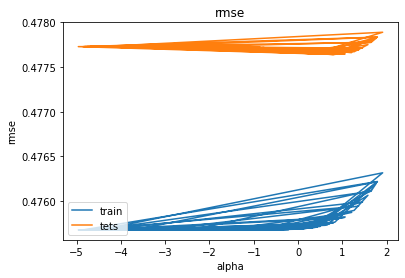

In [26]:
random_grid = {
               'alpha':loguniform(1e-5, 1e2)
               }

model = Ridge()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=False, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std3, y_train_S3)
# summarize
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][results.best_index_])
print('Config: %s' % results.best_params_)

plot_scores_single(results, 'alpha', log=True)

**FINAL MODEL TRAINING AND SAVING**

* best_alpha = 6.715

In [27]:
best_params = {'alpha': 6.715}

scaler_ridge = StandardScaler()
X_std3 = scaler_ridge.fit_transform(X_train_S3)

ridge_model = Ridge(**best_params)
ridge_model.fit(X_std3, y_train_S3)

pickle.dump(scaler_ridge, open('base_models/F1_scaler_ridge.pkl', "wb"))
pickle.dump(ridge_model, open('base_models/F1_ridge.pkl', "wb"))

## 4. Lasso Regression

In [28]:
X_train_S4 = Train_X1.sample(frac=0.85, random_state=104, axis=0)
y_train_S4 = Train_Y1.sample(frac=0.85, random_state=104, axis=0)

print(X_train_S4.shape, y_train_S4.shape)
print('number of unique datapoints', len(set(X_train_S4.index)))

(25182, 71) (25182,)
number of unique datapoints 25182


In [29]:
scaler = StandardScaler()
X_std4 = scaler.fit_transform(X_train_S4)

best rmse: test 0.47839884614391837 train 0.47663291685304315
Config: {'alpha': 6.672367170464204e-05}


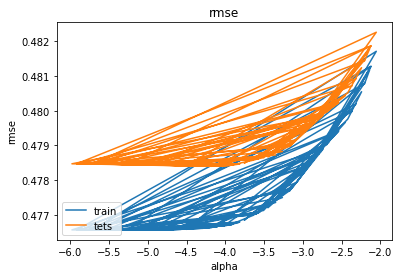

In [30]:
random_grid = {
               'alpha':loguniform(1e-6, 1e-2)
               }

model = Lasso()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=False, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std4, y_train_S4)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('Config: %s' % results.best_params_)

plot_scores_single(results, 'alpha', log=True)

**FINAL MODEL TRAINING AND SAVING**

* best_alpha = 'alpha': 6.6723-05



In [31]:
best_params = {'alpha':6.6723e-05}

scaler_lasso = StandardScaler()
X_std4 = scaler_lasso.fit_transform(X_train_S4)

lasso_model = Lasso(**best_params)
lasso_model.fit(X_std4, y_train_S4)

pickle.dump(scaler_lasso, open('base_models/F1_scaler_lasso.pkl', "wb"))
pickle.dump(lasso_model, open('base_models/F1_lasso.pkl', "wb"))

## 5. Elastic Net Regression

In [32]:
X_train_S5 = Train_X1.sample(frac=0.85, random_state=105, axis=0)
y_train_S5 = Train_Y1.sample(frac=0.85, random_state=105, axis=0)

print(X_train_S5.shape, y_train_S5.shape)
print('number of unique datapoints', len(set(X_train_S5.index)))

(25182, 71) (25182,)
number of unique datapoints 25182


In [33]:
scaler = StandardScaler()
X_std5 = scaler.fit_transform(X_train_S5)

In [36]:
random_grid = {
               'alpha': loguniform(1e-5, 1e2),
               'l1_ratio': uniform(0,1)
               }

model = ElasticNet()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 100, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=False, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std5, y_train_S5)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('Config: %s' % results.best_params_)

#plot_scores_single(results, 'alpha', log=True)

best rmse: test 0.47700725540868677 train 0.474876854160613
Config: {'alpha': 0.0003995647418015854, 'l1_ratio': 0.07697990982879299}


**FINAL MODEL TRAINING AND SAVING**

* best_params = {'alpha': 0.0004, 'l1_ratio': 0.077}

In [37]:
best_params = {'alpha': 0.0004, 'l1_ratio': 0.077}

scaler_en = StandardScaler()
X_std5 = scaler_en.fit_transform(X_train_S5)

en_model = ElasticNet(**best_params)
en_model.fit(X_std5, y_train_S5)

pickle.dump(scaler_en, open('base_models/F1_scaler_en.pkl', "wb"))
pickle.dump(en_model, open('base_models/F1_en.pkl', "wb"))

## 6. SVR

In [39]:
X_train_S6 = Train_X1.sample(frac=0.85, random_state=106, axis=0)
y_train_S6 = Train_Y1.sample(frac=0.85, random_state=106, axis=0)

print(X_train_S6.shape, y_train_S6.shape)
print('number of unique datapoints', len(set(X_train_S6.index)))

(25182, 71) (25182,)
number of unique datapoints 25182


In [40]:
scaler = StandardScaler()
X_std6 = scaler.fit_transform(X_train_S6)

In [43]:
random_grid = {
               'C': loguniform(1e-2, 1e2), 
               'gamma': loguniform(1e-4, 1e1)
               }

model = SVR()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 20, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=20, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std6, y_train_S6)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('Config: %s' % results.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 26

best rmse: test 0.47723002795060127 train 0.43480257441327036
Config: {'C': 0.16480446427978965, 'gamma': 0.04205156450913869}


**FINAL MODEL TRAINING AND SAVING**

* best params -> {'C': 0.1648, 'gamma': 0.04205}

In [45]:
best_params = {'C': 0.1648, 'gamma': 0.04205}

scaler_svr = StandardScaler()
X_std6 = scaler_svr.fit_transform(X_train_S6)

svr_model = SVR(**best_params)
svr_model.fit(X_std6, y_train_S6)

pickle.dump(scaler_svr, open('base_models/F1_scaler_svr.pkl', "wb"))
pickle.dump(svr_model, open('base_models/F1_svr.pkl', "wb"))

## 7. Decision Tree Regressor

In [47]:
X_train_S7 = Train_X1.sample(frac=0.85, random_state=107, axis=0)
y_train_S7 = Train_Y1.sample(frac=0.85, random_state=107, axis=0)

print(X_train_S7.shape, y_train_S7.shape)
print('number of unique datapoints', len(set(X_train_S7.index)))

(25182, 71) (25182,)
number of unique datapoints 25182


In [48]:
random_grid = {
               #'criterion' : ['mse', 'mae'],
               'max_depth' : randint(2, 15),
               'max_features' : uniform(0, 1),
               'min_samples_leaf' : [2, 10, 20, 50, 100, 1000]
               }

model = DecisionTreeRegressor(criterion='mse', min_samples_leaf=100)
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 200, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=20, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_train_S7, y_train_S7)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('Config: %s' % results.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

best rmse: test 0.4784188949443182 train 0.4696892393919754
Config: {'max_depth': 6, 'max_features': 0.5722924691708383, 'min_samples_leaf': 50}


**FINAL MODEL TRAINING AND SAVING**
* best_params = {'max_depth': 6, 'max_features':0.5723, 'min_samples_leaf': 50}

In [49]:
best_params = {'max_depth': 6, 'max_features': 0.5723, 'min_samples_leaf': 50}

dt_model = DecisionTreeRegressor(**best_params)
dt_model.fit(X_train_S7, y_train_S7)

pickle.dump(dt_model, open('base_models/F1_dt.pkl', "wb"))

# Dataset for Meta Classifier

**LOADING THE MODELS**

In [50]:
#Loading the standard scalers
F1_scaler_ridge = pickle.load(open('base_models/F1_scaler_ridge.pkl', 'rb'))
F1_scaler_lasso = pickle.load(open('base_models/F1_scaler_lasso.pkl', 'rb'))
F1_scaler_en = pickle.load(open('base_models/F1_scaler_en.pkl', 'rb'))
F1_scaler_svr = pickle.load(open('base_models/F1_scaler_svr.pkl', 'rb'))

#Loading the models 
F1_xgb = pickle.load(open('base_models/F1_xgb.pkl', 'rb'))
F1_rf = pickle.load(open('base_models/F1_rf.pkl', 'rb'))
F1_ridge = pickle.load(open('base_models/F1_ridge.pkl', 'rb'))
F1_lasso = pickle.load(open('base_models/F1_lasso.pkl', 'rb'))
F1_en = pickle.load(open('base_models/F1_en.pkl', 'rb'))
F1_svr = pickle.load(open('base_models/F1_svr.pkl', 'rb'))
F1_dt = pickle.load(open('base_models/F1_dt.pkl', 'rb'))

**TRAIN DATA**

In [51]:
pred_xgb = F1_xgb.predict(Train_X2) 
pred_rf = F1_rf.predict(Train_X2) 
pred_ridge = F1_ridge.predict(F1_scaler_ridge.transform(Train_X2)) 
pred_lasso = F1_lasso.predict(F1_scaler_lasso.transform(Train_X2)) 
pred_en = F1_en.predict(F1_scaler_en.transform(Train_X2)) 
pred_svr = F1_svr.predict(F1_scaler_svr.transform(Train_X2)) 
pred_dt = F1_dt.predict(Train_X2) 

In [52]:
arr = np.hstack((pred_xgb.reshape(-1,1),
                 pred_rf.reshape(-1,1), 
                 pred_dt.reshape(-1,1), 
                 pred_svr.reshape(-1,1),
                 pred_ridge.reshape(-1,1),
                 pred_lasso.reshape(-1,1), 
                 pred_en.reshape(-1,1)))

F1_df = pd.DataFrame(arr, columns=['f1_xgb', 'f1_rf', 'f1_dt', 'f1_svr', 'f1_ridge', 'f1_lasso', 'f1_en'], index=Train_X2.index)
F1_df.to_pickle('meta_model/Train_X2_F1.pkl')

**TEST DATA**

In [53]:
pred_xgb = F1_xgb.predict(Test_X) 
pred_rf = F1_rf.predict(Test_X) 
pred_ridge = F1_ridge.predict(F1_scaler_ridge.transform(Test_X)) 
pred_lasso = F1_lasso.predict(F1_scaler_lasso.transform(Test_X)) 
pred_en = F1_en.predict(F1_scaler_en.transform(Test_X)) 
pred_svr = F1_svr.predict(F1_scaler_svr.transform(Test_X)) 
pred_dt = F1_dt.predict(Test_X) 

In [54]:
arr = np.hstack((pred_xgb.reshape(-1,1),
                 pred_rf.reshape(-1,1), 
                 pred_dt.reshape(-1,1), 
                 pred_svr.reshape(-1,1),
                 pred_ridge.reshape(-1,1),
                 pred_lasso.reshape(-1,1), 
                 pred_en.reshape(-1,1)))

F1_df = pd.DataFrame(arr, columns=['f1_xgb', 'f1_rf', 'f1_dt', 'f1_svr', 'f1_ridge', 'f1_lasso', 'f1_en'], index=Test_X.index)
F1_df.to_pickle('meta_model/Test_X_F1.pkl')